# Spam classification using multinomial naive bayes

## Structure

- Import libaries

- Data Cleaning 

- Exploratory Data Analysis 

- Data Preprocessing (Count Vectorizer)

- Modeling (Multinomial Naive Bayes, Hyperparameter Tuning)

- Model Evaluation

## Import libaries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from wordcount import word_counter #wrote function to get all words and their specifit frequency in all messages

In [3]:
df = pd.read_csv("spam.csv", encoding ="latin-1", usecols=["v1","v2"])
df.columns = ["label", "message"]

## Exploratory Data Analysis

In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


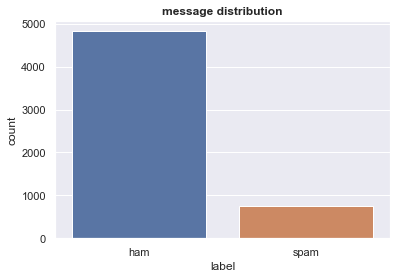

In [6]:
#counts number of occurences of unique values in category (ham and spam)
sns.set()
_ = sns.countplot(data = df, x=df["label"]).set_title("message distribution", fontweight="bold")
plt.show()

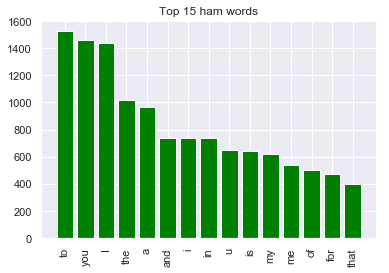

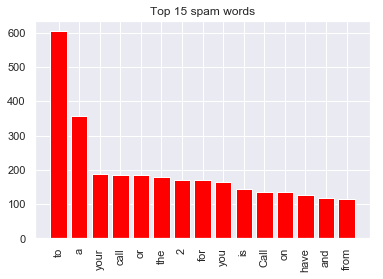

In [7]:
ham = word_counter(df[df["label"]=="ham"]["message"])
spam = word_counter(df[df["label"]=="spam"]["message"])
ham_sorted = sorted(ham.items(), key=lambda kv: kv[1], reverse=True)
spam_sorted = sorted(spam.items(), key=lambda kv: kv[1], reverse=True)

top15_spam = spam_sorted[:15]
top15_ham = ham_sorted[:15]

#slice word and occurences so I can easily plot them
top_words_ham = [i[0] for i in top15_ham]  #(to,1530) [0]=to [1]=1530  
top_occurences_ham = [i[1] for i in top15_ham]
top_words_spam = [i[0] for i in top15_spam]       
top_occurences_spam = [i[1] for i in top15_spam]

plt.bar(top_words_ham, top_occurences_ham, color = 'green')
plt.title("Top 15 ham words")
plt.xticks(rotation='vertical')
plt.show()

plt.bar(top_words_spam, top_occurences_spam, color = "red")
plt.title("Top 15 spam words")
plt.xticks(rotation='vertical')
plt.show()

## Data Preprocessing

Top 15 spam and no spam words have many similarities as both of them represent common words that are used in many messages, wether it being spam or no spam (ham). Those so-called 'stop-words' have to be removed before fitting the messages to the model, because they dont help in distinguising between spam or no spam (ham). Same goes for words that occur very rarely. To avoid overfitting those have to be removed aswell. I will do this by specifying the hyperparameters min_df, max_features and stop_words of the CountVectorizer

In [8]:
X = df["message"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)

cv = CountVectorizer(min_df = 0.01, max_features = 300, stop_words = 'english') #1% / 300 occurences
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_cv

<4179x108 sparse matrix of type '<class 'numpy.int64'>'
	with 9488 stored elements in Compressed Sparse Row format>

As you can see in the output, a sparse matrix has been created.

<4197x108 sparse matrixs> means that there are 4197 messages in our training data and 108 columns, one for each feature that are left after the CV-Transformation (low frequency words, high frequency words/stop words have been removed).

Lets take a closer look as to how this matrix looks like and what informations we can extract from it. Firstly I will check what features/words are left and then go over the outputs of the CV-Transformation with the first spam message as example

#### Example: CountVectorizer Transformation on first spam message

Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

In [9]:
features = cv.get_feature_names()
print('All features/words after transformation:\n \n{}\n'.format(features))
print('----------------------------------------------------\n\nFirst spam message: \n')
print(X_train[2])
print("\n")
print('----------------------------------------------------\n')
print('(Message, Word-Column) Frequency\n\n{}\n'.format(X_train_cv[1]))
print('----------------------------------------------------\n\n')
print('Sparse-Matrix Array (one entry for each word in and their frequency in message 1):\n \n{}\n'.format(X_train_cv.toarray()[0]))
print('----------------------------------------------------\n\n')
print('Features names after CV-Transformation: {} {} {} {} {} {} {}\n'.format(features[9],
                                                                  features[23],
                                                                  features[37],
                                                                  features[58],
                                                                  features[78],
                                                                  features[89],
                                                                  features[91]))

All features/words after transformation:
 
['150p', '50', 'amp', 'ask', 'babe', 'buy', 'care', 'cash', 'claim', 'com', 'come', 'coming', 'contact', 'cos', 'customer', 'da', 'day', 'dear', 'did', 'doing', 'don', 'dont', 'fine', 'free', 'friend', 'going', 'gonna', 'good', 'got', 'great', 'gt', 'happy', 'hey', 'hi', 'home', 'hope', 'im', 'just', 'know', 'later', 'let', 'life', 'like', 'll', 'lol', 'lor', 'love', 'lt', 'make', 'meet', 'message', 'min', 'miss', 'mobile', 'money', 'morning', 'msg', 'need', 'new', 'night', 'number', 'oh', 'ok', 'phone', 'pick', 'place', 'pls', 'prize', 'really', 'reply', 'right', 'said', 'say', 'send', 'sent', 'service', 'soon', 'sorry', 'stop', 'sure', 'tell', 'text', 'thanks', 'thing', 'think', 'time', 'today', 'tomorrow', 'tonight', 'txt', 'uk', 'ur', 'urgent', 've', 'wait', 'wan', 'want', 'wat', 'way', 'week', 'went', 'win', 'won', 'work', 'www', 'yeah', 'yes', 'ì_']

----------------------------------------------------

First spam message: 

Free entry i

As shown above, the CountVecorizer succesfully filtered out words that we should not fit our model with (e.g. stopwords)

## Modeling

In [10]:
model = MultinomialNB()
model.fit(X_train_cv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Model Evaluation

- Accuracy
- Confusion Matrix
- Classificaion Report

Format of Confusion-Matrix:

| True ham | False spam
| --- | ---- |
| False ham | True spam |

Accuracy: 0.9597989949748744

              precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1206
        spam       0.88      0.81      0.84       187

   micro avg       0.96      0.96      0.96      1393
   macro avg       0.92      0.90      0.91      1393
weighted avg       0.96      0.96      0.96      1393



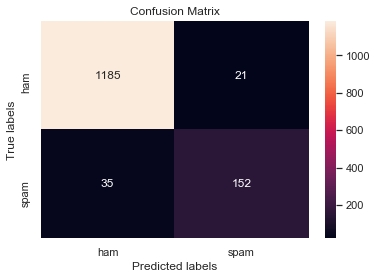

In [11]:
y_test_pred = model.predict(X_test_cv)

print('Accuracy: {}\n'.format(accuracy_score(y_test, y_test_pred)))


cm = confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ham', 'spam']); ax.yaxis.set_ticklabels(['ham', 'spam']);

print(classification_report(y_test, y_test_pred))

The Metrics of the Spamfilter are already pretty good. One think I could try to improve is the 
specificity (FN/ (TN+FP)) because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter), which happened 21/1393 times in the testing data.

## Hyperparameter Tuning

- alpha: Additive (Laplace/Lidstone) smoothing parameter (avoids probabilities from being 0 if a combination is not given in the training set)
- fit-prior: Whether to learn class prior probabilities or not. If false, a uniform prior will be used.

In [12]:
alpha_space = np.linspace(0.1,1, 50)
parameters = {'alpha' : alpha_space, 'fit_prior' : [True,False]}

nb_clf = GridSearchCV(model, parameters, cv=5, refit = True, scoring='accuracy')
nb_clf.fit(X_train_cv, y_train)

r2 = nb_clf.score(X_test_cv, y_test)
print("Tuned Hyperparameter: {}".format(nb_clf.best_params_))
print("Tuned Hyperparameter R squared: {}".format(r2))

Tuned Hyperparameter: {'alpha': 0.9448979591836735, 'fit_prior': True}
Tuned Hyperparameter R squared: 0.9597989949748744


Lets take a closer look at the features that help our modle to distinguish between spam and ham and their coefficients/log probabilities 

In [33]:
#feature_log_prob_ : array, shape (n_classes, n_features)
#Empirical log probability of features given a class, P(x_i|y).

#coef_ : array, shape (n_classes, n_features)
#Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.


# Get the class labels: class_labels
class_labels = nb_clf.best_estimator_.classes_

# Extract the features: feature_names
feature_names = cv.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_clf.best_estimator_.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print("\ntop 20 weighted ham (no spam) features\n\n")
for feature in feat_with_weights[:20]:
    print(feature)

# Print the second class label and the bottom 20 feat_with_weights entries
print("\ntop 20 weighted spam features\n\n")
for feature in feat_with_weights[-20:]:
    print(feature)


top 20 weighted ham (no spam) features


(-7.801269358617349, 'amp')
(-7.801269358617349, 'ask')
(-7.801269358617349, 'coming')
(-7.801269358617349, 'cos')
(-7.801269358617349, 'da')
(-7.801269358617349, 'doing')
(-7.801269358617349, 'fine')
(-7.801269358617349, 'gonna')
(-7.801269358617349, 'gt')
(-7.801269358617349, 'later')
(-7.801269358617349, 'lol')
(-7.801269358617349, 'lor')
(-7.801269358617349, 'lt')
(-7.801269358617349, 'morning')
(-7.801269358617349, 'pick')
(-7.801269358617349, 'said')
(-7.801269358617349, 'say')
(-7.801269358617349, 'sure')
(-7.801269358617349, 'wait')
(-7.801269358617349, 'went')

top 20 weighted spam features


(-3.9391537719246923, '50')
(-3.9171482135826095, 'com')
(-3.853895887693418, 'new')
(-3.853895887693418, 'win')
(-3.8138464051350436, 'uk')
(-3.7753393100167982, '150p')
(-3.738260193846462, 'won')
(-3.720223780289703, 'send')
(-3.602331313492755, 'cash')
(-3.5865692784740117, 'just')
(-3.4686905017015324, 'prize')
(-3.441270827936724, 'reply')
(

#### Function to classify spam / ham (no spam)

In [14]:
def classifier(message):

    transformed = cv.transform([message])
    prediction = model.predict(transformed)

    if prediction == "ham":
        return "This message is no spam!"
    else:
        return "This message is spam!"
    
print('Message: sign up for free cash = {}'.format(classifier("sign up for free cash")))
print('Message: good morning, are you coming?  = {}'.format(classifier("good morning, are you coming?")))

Message: sign up for free cash = This message is spam!
Message: good morning, are you coming?  = This message is no spam!
